In [1]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
%matplotlib inline

from ann import ANN

In [2]:
n_train_samples = 100
X, y = make_moons(n_samples=n_samples, noise=0.25)
y = y[:,np.newaxis]

In [3]:
X, y = X.astype('float32'), y.astype('float32')
X.shape, y.shape

((100, 2), (100, 1))

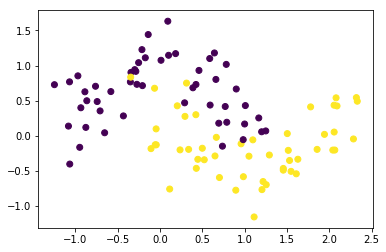

In [4]:
plt.scatter(X[:,0], X[:,1], c = y[:,0])

In [5]:
ann = ANN(2, 1, [40, 40], activation=tf.nn.sigmoid, bayesian=True, lrep=True)

In [6]:
x_ = tf.placeholder(tf.float32, shape=[None,2])
y_ = tf.placeholder(tf.float32, shape=[None,1])

In [7]:
kl_scaler = tf.placeholder_with_default(30., (), name='kl_scaler')

In [8]:
nsam = 8
def pack(x):
    x_ = x
    x = tf.stack([x]*nsam, axis=0)
    x = tf.reshape(x, [-1, int(x.shape[-1])])
    return x

def unpack(x):
    x = tf.reshape(x, [nsam, -1, int(x.shape[-1])])
    return x

In [9]:
y_pred = ann(pack(x_))

In [10]:
y_pred = unpack(y_pred)

In [11]:
y_pred.shape

TensorShape([Dimension(8), Dimension(None), Dimension(1)])

In [12]:
#y_pred = y_pred[0]
#ann.logits = ann.logits[0]

In [13]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.reshape(tf.stack([y_]*8, axis=0), [-1,1])
                                                              , logits=ann.logits))\
+ (ann.loss/n_train_samples)/kl_scaler

In [14]:
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=ann.logits)) + ann.loss/n_samples

In [15]:
#loss /= 300

In [16]:
tf.summary.scalar('ELBO', loss)

<tf.Tensor 'ELBO:0' shape=() dtype=string>

In [17]:
train_op = tf.train.AdamOptimizer(0.01).minimize(loss)

In [18]:
sess = tf.InteractiveSession()

In [19]:
tf.global_variables_initializer().run()

In [20]:
sum_merge = tf.summary.merge_all()

In [21]:
!rm -R /tmp/lrep/

In [22]:
writer = tf.summary.FileWriter('/tmp/lrep')

In [23]:
writer.add_graph(tf.get_default_graph())

In [24]:
epoch = 0

In [101]:
for epoch in range(epoch, 1000000):
    summary, _ = sess.run([sum_merge, train_op], {x_:X, y_:y, kl_scaler: 4})
    
    if epoch % 300 == 0:
        writer.add_summary(summary, global_step=epoch)

KeyboardInterrupt: 

In [102]:
mi, ma = X.min(axis=0)[0], X.max(axis=0)[0]
xs, ys = np.meshgrid(*[np.arange(mi, ma, 0.05)]*2)

dim = xs.shape
xs, ys = xs.reshape((-1,)), ys.reshape((-1,))

xx = np.stack([xs, ys], axis=-1)

yy = np.mean([y_pred.eval({x_:xx}) for _ in range(30)], axis=0).mean(axis=0)

yy = yy.reshape(dim)

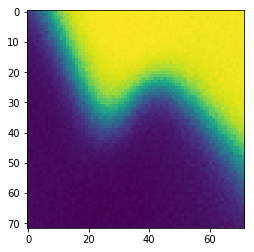

In [103]:
plt.imshow(yy)
plt.show()